# Freyberg Model Schur Complement Example
This example uses a synthetic model (described below) to illustrate the `pyemu` capabilities of the Schur complement for calculating posterior covariance.

Note that, in addition to `pyemu`, this notebook relies on `flopy`. `flopy` can be obtained (along with installation instructions) at https://github.com/modflowpy/flopy.

In [5]:
%matplotlib inline
from __future__ import print_function
import os
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle as rect
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", message="ModflowDis.sr is deprecated. use Modflow.sr")
from mpl_toolkits.axes_grid1 import make_axes_locatable


## Model background
This example is based on the synthetic classroom model of Freyberg(1988).  The  model is a 2-dimensional MODFLOW model with 1 layer,  40 rows, and 20 columns.  The model has 2 stress periods: an initial steady-state stress period used for calibration, and a 5-year transient stress period.  The calibration period uses the recharge and well flux of Freyberg(1988); the last stress period use 25% less recharge and 25% more pumping to represent future conditions for a forecast period.

The inverse problem has 761 parameters: hydraulic conductivity of each active model cell, calibration and forecast period recharge multipliers, storage and specific yield, calibration and forecast well flux for each of the six wells, and river bed conductance for each 40 cells with river-type boundary conditions.  The inverse problem has 13 head obseravtions, measured at the end of the steady-state calibration period.  The forecasts of interest include the sw-gw exchange flux during both stress periods (observations named ```sw_gw_0``` and ``sw_gw_1``), and the water level in well cell 6 located in at row 28 column 5 at the end of the stress periods (observations named ```or28c05_0``` and ```or28c05_1```).  The forecasts are included in the Jacobian matrix as zero-weight observations. The model files, pest control file and previously-calculated jacobian matrix are in the `freyberg/` folder


Freyberg, David L. "AN EXERCISE IN GROUND‐WATER MODEL CALIBRATION AND PREDICTION." Groundwater 26.3 (1988): 350-360.

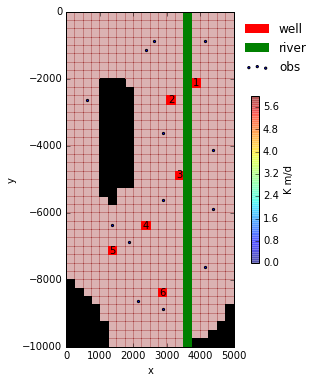

In [6]:
import flopy

# load the model
model_ws = os.path.join("Freyberg","extra_crispy")
ml = flopy.modflow.Modflow.load("freyberg.nam",model_ws=model_ws)

# plot some model attributes
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111,aspect="equal")
ml.upw.hk.plot(axes=[ax],colorbar="K m/d",alpha=0.3)
ml.wel.stress_period_data.plot(axes=[ax])
ml.riv.stress_period_data.plot(axes=[ax])

# plot obs locations
obs = pd.read_csv(os.path.join("freyberg","misc","obs_rowcol.dat"),delim_whitespace=True)
obs_x = [ml.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [ml.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
ax.scatter(obs_x,obs_y,marker='.',label="obs")

#plot names on the pumping well locations
wel_data = ml.wel.stress_period_data[0]
wel_x = ml.sr.xcentergrid[wel_data["i"],wel_data["j"]]
wel_y = ml.sr.ycentergrid[wel_data["i"],wel_data["j"]]
for i,(x,y) in enumerate(zip(wel_x,wel_y)):
    ax.text(x,y,"{0}".format(i+1),ha="center",va="center")

ax.set_ylabel("y")
ax.set_xlabel("x")

ax.add_patch(rect((0,0),0,0,label="well",ec="none",fc="r"))
ax.add_patch(rect((0,0),0,0,label="river",ec="none",fc="g"))

ax.legend(bbox_to_anchor=(1.5,1.0),frameon=False)
plt.savefig("domain.pdf")

The plot shows the Freyberg (1988) model domain.  The colorflood is the hydraulic conductivity $\left(\frac{m}{d}\right)$.  Red and green cells correspond to well-type and river-type boundary conditions. Blue dots show the locations of water levels used for calibration.

## Using `pyemu`

In [7]:
import pyemu

First we need to create a linear_analysis object of the `schur`  derived type, which replicates the behavior of the `PREDUNC` suite of PEST for calculating posterior parameter covariance.  We pass it the name of the Jacobian matrix file.  Since we don't pass an explicit argument for `parcov` or `obscov`, `pyemu` attempts to build them from the parameter bounds and observation weights in a pest control file (.pst) with the same base case name as the Jacobian.  This assumes that the bounds represent the mean value + and - 2 times the standard deviation.

Since we are interested in forecast uncertainty as well as parameter uncertainty, we also pass the names of the forecast sensitivity vectors we are interested in, which are stored in the Jacobian as well.  Note that the `forecasts` argument can be a mixed list of observation names, other Jacobian files or PEST-compatible ASCII matrix files.

In [8]:
# get the list of forecast names from the pest++ argument in the pest control file
jco = os.path.join("freyberg","freyberg.jcb") # just set the path and filename for the jco file
pst = pyemu.Pst(jco.replace("jcb","pst"))     # use the jco name with extention "pst" for the control file
la = pyemu.Schur(jco=jco, forecasts=pst.pestpp_options["forecasts"].split(','),verbose=False)
print("observations,parameters in Jacobian:",la.jco.shape)


observations,parameters in Jacobian: (1408, 761)


##  General parameter uncertainty analysis--evaluating posterior parameter covariance
Let's calculate and save the posterior parameter covariance matrix. In this linear analysis, the posterior covariance represents the updated covariance following notional calibration as represented by the Jacobian matrix and both prior parameter and epistemic observation covariance matrices using the Schur complement:

In [9]:
la.posterior_parameter.to_ascii(jco+"_post.cov") #writes posterior covariance to a text file

You can open this file (it will be called `freyberg.jcb_post.cov`) in a text editor to examine.  The diagonal of this matrix is the posterior variance of each parameter. Since we already calculated the posterior parameter covariance matrix, additional calls to the `posterior_parameter` decorated methods only require access--they do not recalculate the matrix:


In [10]:
la.posterior_parameter.to_dataframe().sort_index().sort_index(axis=1).iloc[0:3,0:3] #easy to read in the notebook

,hkr00c00,hkr00c01,hkr00c02
hkr00c00,2.499965e-01,-8.837002e-07,-0.000005
hkr00c01,-8.837002e-07,2.499910e-01,-0.000021
hkr00c02,-4.635569e-06,-2.085084e-05,0.249947


We can see the posterior variance of each parameter along the diagonal of this matrix. Now, let's make a simple plot of prior vs posterior uncertainty for the 761 parameters. The ``.get_parameters_summary()`` method is the easy way:

,percent_reduction,post_var,prior_var
rch_1,49.884568,0.000238,0.000475
hkr30c15,31.278933,0.171803,0.250000
hkr03c11,26.494859,0.183763,0.250000
hkr34c09,25.096673,0.187258,0.250000
hkr04c10,24.712660,0.188218,0.250000
hkr22c12,22.009284,0.194977,0.250000
hkr25c06,21.114649,0.197213,0.250000
hkr35c12,19.869449,0.200326,0.250000
hkr35c10,18.608329,0.203479,0.250000
hkr04c16,17.240172,0.206900,0.250000


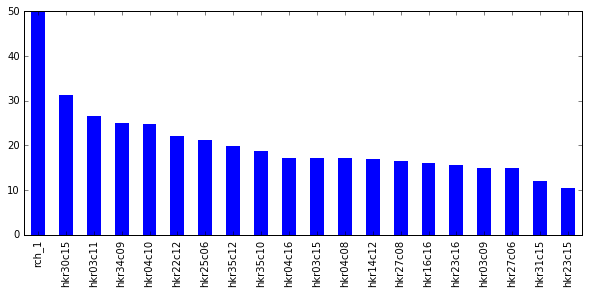

In [11]:
#get the parameter uncertainty dataframe and sort it
par_sum = la.get_parameter_summary().sort_values("percent_reduction",ascending=False)
#make a bar plot of the percent reduction ((prior - posterior) / prior) for the first 20 parameters 
par_sum.loc[par_sum.index[:20],"percent_reduction"].plot(kind="bar",figsize=(10,4),edgecolor="none")
#echo the first 10 entries
par_sum.iloc[0:10,:]

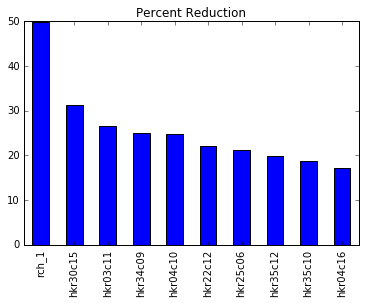

In [12]:
# we can plot up the top 10 percent reductions
par_sum.iloc[0:10,:]['percent_reduction'].plot(kind='bar')
plt.title('Percent Reduction')

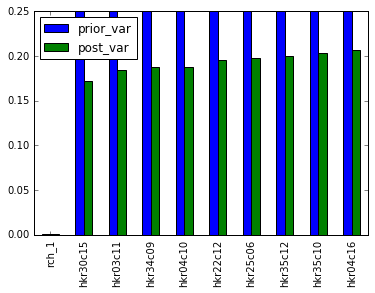

In [13]:
# we can plot up the prior and posterior variance of the top 10 percent reductions
par_sum.iloc[0:10,:][['prior_var','post_var']].plot(kind='bar')

We can see that calibrating the model to the 13 water levels reduces the uncertainty of the calibration period recharge parameter (`rch_0`) by 50%.  Additionally, the hydraulic conductivity of many model cells is also reduced.  

Now lets look at the other end of the parameter uncertainty summary -- the values with the _least_ amount of uncertainty reduction.  Note that calling ``get_parameter_summary()`` again results in no additional computation but is just accessing information already calculated

,percent_reduction,post_var,prior_var
hkr01c19,0.000000e+00,0.250000,0.250000
hkr00c19,0.000000e+00,0.250000,0.250000
wf2_2,0.000000e+00,0.014228,0.014228
sy,0.000000e+00,0.250000,0.250000
wf1_2,0.000000e+00,0.014228,0.014228
rcond19,0.000000e+00,0.250000,0.250000
wf5_2,0.000000e+00,0.014228,0.014228
rcond39,0.000000e+00,0.250000,0.250000
hkr39c14,0.000000e+00,0.250000,0.250000
wf6_2,0.000000e+00,0.014228,0.014228


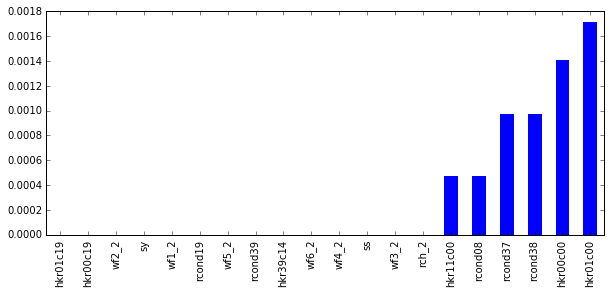

In [14]:
# sort in increasing order
par_sum = la.get_parameter_summary().sort_values("percent_reduction") #without 'ascending=False'
# plot the first 20
par_sum.loc[par_sum.index[:20],"percent_reduction"].plot(kind="bar",figsize=(10,4),edgecolor="none")
#echo the first 10 
par_sum.iloc[0:20,:]

We see that several parameters are unaffected by calibration - these are mostly parameters that represent forecast period uncertainty (parameters that end with ```_2```), but there are also some hydraulic conductivities that are uninformed by the 13 water level observations.

The naming conventions for the hydraulic conductivity parameters include their row and column location (starting at 0 rather than 1) so, for example, `hkr39r14` indicates hydraulic conductivity in row 39, column 14. This location is in a constant head cell, so it makes sense it would be uninformed by head values anywhere in the model. The other hydraulic conductivity values are in the upper right hand corner of the model, far from the observations in a stagnant area with limited groundwater flow.

We can also make a map of uncertainty reduction for the hydraulic conductivity parameters using some ```flopy``` action

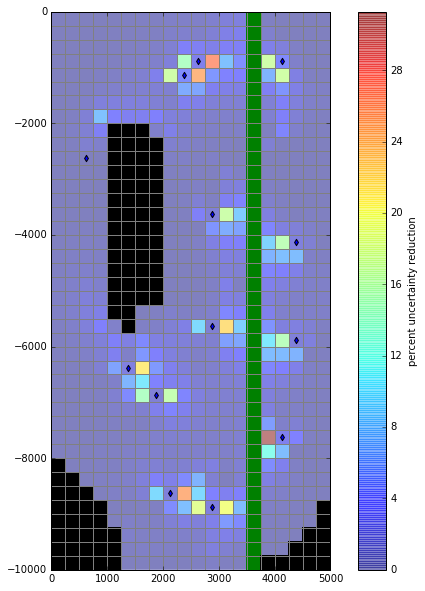

In [15]:
hk_pars = par_sum.loc[par_sum.groupby(lambda x:"hk" in x).groups[True],:]
hk_pars.loc[:,"names"] = hk_pars.index
names = hk_pars.names
# use the parameter names to parse out row and column locations
hk_pars.loc[:,"i"] = names.apply(lambda x: int(x[3:5]))
hk_pars.loc[:,"j"] = names.apply(lambda x: int(x[6:8]))
# set up an array of the value -1 the same shape as the HK array in the UPW package
unc_array = np.zeros_like(ml.upw.hk[0].array) - 1
# fill the array with percent reduction values
for i,j,unc in zip(hk_pars.i,hk_pars.j,hk_pars.percent_reduction):
    unc_array[i,j] = unc 
# setting the array values that are still -1 (e.g. no percent reduction value in the cell)
# to np.NaN so that they don't get displayed on the plot
unc_array[unc_array == -1] = np.NaN

# plot some model attributes
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111,aspect="equal")
cb = ax.imshow(unc_array,interpolation="none",alpha=0.5,extent=ml.dis.sr.get_extent())
plt.colorbar(cb,label="percent uncertainty reduction")
#ml.wel.stress_period_data.plot(axes=[ax])
ml.riv.stress_period_data.plot(axes=[ax])
# plot obs locations
obs = pd.read_csv(os.path.join("freyberg","misc","obs_rowcol.dat"),delim_whitespace=True)
obs_x = [ml.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [ml.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
ax.scatter(obs_x,obs_y,marker='d')
modelmap = flopy.plot.ModelMap(model=ml)
modelmap.plot_grid()




As expected, most of the information in the observations is reduces uncertainty for the hydraulic conductivity parameters near observations themselves. Areas farther from the observations experience less reduction in uncertainty due to calibration. 

## Forecast uncertainty
Now let's examine the prior and posterior variance of the forecasts. The uncertainty in parameters directly impacts the uncertainty of forecasts made with the model. Four forecasts were identified for analysis, as described above:

1. `sw_gw_0`: the surface water/groundwater exchange during the calibration stress period
2. `sw_gw_1`: the surface water/groundwater exchange during the prediction stress period
3. `or28c05_0`: the head in well cell 6 (row 28, column 5) at the end of the calibration stress period
4. `or28c05_1`: the head in well cell 6 (row 28, column 5) at the end of the prediction stress period


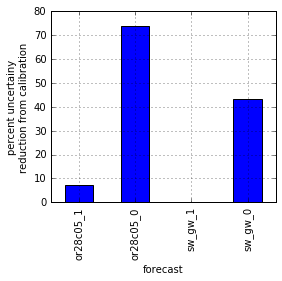

In [16]:
# get the forecast summary then make a bar chart of the percent_reduction column
fig = plt.figure(figsize=(4,4))
ax = plt.subplot(111)
ax = la.get_forecast_summary().percent_reduction.plot(kind='bar',ax=ax,grid=True)
ax.set_ylabel("percent uncertainy\nreduction from calibration")
ax.set_xlabel("forecast")
plt.tight_layout()
plt.savefig("forecast_sum.pdf")

Notice the spread on the uncertainty reduction: some forecasts benefit more from calibration than others.  For example, ```or28c05_0```, the calibration-period water level forecast, benefits from calibration since its uncertainty is reduced by 75%, while ```sw_gw_1```, the forecast-period surface-water groundwater exchange forecast does not benefit from calibration - its uncertainty is unchanged by calibration

# Data worth analysis

## Overview
Data worth can be broken into two main categories: the worth of data pertaining directly to parameters, and the data pertaining to observations.

There are two main applications of data worth analysis. One is to evaluate the worth of observations in an existing network of observations, and the other is to evaluate the value of potential new observations. 

## Data worth--evaluating the value of existing observations
Now, let's try to identify which observations are most important to reducing the posterior uncertainty (e.g.the forecast worth of every observation).  We simply recalculate Schur's complement without some observations and see how the posterior forecast uncertainty increases

```get_removed_obs_group_importance()``` is a thin wrapper that calls the underlying ```get_removed_obs_importance()``` method using the observation groups in the pest control file and stacks the results into a ```pandas DataFrame```.  This method tests how important non-zero weight observations are for reducing forecast uncertainty. The metric provided is the forecast uncertainty that can be attributed to each observation group. 

This call will test all of the non-forecast, non-zero weight observations in the PEST data set to see which ones are most important. 


In [17]:
la.get_removed_obs_group_importance()

,or28c05_0,or28c05_1,sw_gw_0,sw_gw_1
base,0.104901,1.349353,45266.951772,620442.618112
forecast,0.104901,1.349353,45266.951772,620442.618112
head_cal,0.401023,1.456301,79634.034592,621129.872236


Now let's determine which observations are calibration observations. These are the ones with nonzero weight, accessed from the `pst` object as the `nnz_obs_names` property, which returns a list. We can make it into a dictionary and see that, as expected, it has 13 entries.

In [18]:
print(len(pst.nnz_obs_names))


13


Now we can pass that dictionary to the `la.get_importance_dataframe` method to return the importance of those 13 observations into a dataframe we'll call `df_worth`

In [19]:
df_worth= la.get_removed_obs_importance(pst.nnz_obs_names)

In [20]:
df_worth

,or28c05_0,or28c05_1,sw_gw_0,sw_gw_1
base,0.104901,1.349353,45266.951772,620442.618112
or10c02_0,0.106080,1.349520,50438.518215,620553.778164
or23c17_0,0.104907,1.349489,45890.127094,620456.396643
or25c05_0,0.139213,1.361276,45859.283606,620452.111319
or27c07_0,0.153058,1.378501,45476.473772,620448.729766
or30c16_0,0.104913,1.349405,45486.605342,620449.437222
or03c10_0,0.104901,1.349353,45267.631429,620444.798848
or04c09_0,0.104901,1.349380,45376.309284,620446.560354
or34c08_0,0.105463,1.349361,45546.665830,620550.423439
or35c11_0,0.104953,1.350356,45383.665749,620476.801860


The ```base``` row contains the results of the Schur's complement calculation using all observations.  The increase in posterior forecast uncertainty for each of the 13 water level observations (e.g. or17c17 is the observation in row 18 column 18) show how much forecast uncertainty increases when that particular observation is not used in history matching.  So we see again that each forecast depends on the observations differently.

We can normalize the importance to the maximum importance value to create a metric of data worth which will be between 0 and 100%. Then we can also determine which observation has the highest data worth with respect to each forecast and also report how much reduction in uncertainty it is responsible for (e.g. how much does forecast uncertainty increase if that data point is not used for history matching)



In [21]:
# a little processing of df_worth
df_base = df_worth.loc["base",:].copy()
df_imax = df_worth.apply(lambda x:x-df_base,axis=1).idxmax()
df_max = 100.0 * (df_worth.apply(lambda x:x-df_base,axis=1).max() / df_base)
df_par = pd.DataFrame([df_imax,df_max],index=["most important observation","percent increase when left out"])
df_par

,or28c05_0,or28c05_1,sw_gw_0,sw_gw_1
most important observation,or27c07_0,or27c07_0,or10c02_0,or10c02_0
percent increase when left out,45.9074,2.16014,11.4246,0.0179163


We see that observation ```or27c07_0``` is the most important for the water level forecasts (```or28c05_0``` and ```or28c05_1```), while observation ```or10c02_0``` is the most important for the surface water groundwater exchange forecasts (```sw_gw_0``` and ```sw_gw_1```). Also, observation ```or10c02_0```) results in a much greater increase in uncertainty for forecast ```sw_gw_0``` than it does for ```sw_gw_1```.

## Data worth--evaluating the potential value of new observations
A potential water-level observation for each active model cell was also "carried" in the PEST control file.  This means we can run this same analysis to find the best next place to collect a new water level.  This takes a little longer because it is rerunning the schur's complement calculations many times, so this section can be skipped.

### Define the potential observation locations
First we need a list of the observations with zero weight and that start with `"or"`--- (these are the synthetic proposed locations)

In [22]:
new_obs_list = [i[1].obsnme for i in pst.observation_data.iterrows() 
                if i[1].weight==0 and i[1].obsnme[0:2] =='or' ]

# need to explicitly drop out the two predictions --- temporary kludge
[new_obs_list.remove(i) for i in ['or28c05_0','or28c05_1']]
print (len(new_obs_list))

1395


In [23]:
df_worth_new= la.get_added_obs_importance(base_obslist=pst.nnz_obs_names,
                                          obslist_dict=new_obs_list,reset_zero_weight=True)

In [25]:
df_worth_new.head()

,or28c05_0,or28c05_1,sw_gw_0,sw_gw_1
base,0.104901,1.349353,45266.951772,620442.618112
or29c04_1,0.103422,0.625363,45130.198489,365458.200500
or36c08_0,0.104899,1.349351,45261.815809,620439.968151
or02c11_0,0.104901,1.349353,45262.093231,620442.612803
or21c17_1,0.104901,1.326495,45248.229402,607308.119600


Similar to the value of existing data, these results are specific to the forecast of interest. However, when adding potential new observation data, we are looking at how uncertainty will _decrease_ if a proposed observation is _added_ (this is opposite of looking for the _increase_ in forecast uncertainty if an existing observation is _removed_). 

For each forecast, we can first determine which proposed new observation is most valuable.

In [26]:
# a little processing of df_worth
df_new_base = df_worth_new.loc["base",:].copy()
df_new_imax = df_worth_new.apply(lambda x:df_base-x,axis=1).idxmax()
df_new_worth = 100.0 * (df_worth_new.apply(lambda x:df_base-x,axis=1) / df_new_base)
df_new_max = df_new_worth.max()
df_par_new = pd.DataFrame([df_new_imax,df_new_max],index=["most important observation","percent decrease when added"])
df_par_new

,or28c05_0,or28c05_1,sw_gw_0,sw_gw_1
most important observation,or29c05_0,or13c02_1,or08c03_1,or13c02_1
percent decrease when added,6.26931,66.3488,0.961129,52.3342


### Some processing for plotting...


In [29]:
df_new_worth_plot = df_new_worth[df_new_worth.index != 'base'].copy()
df_new_worth_plot.loc[:,'names'] = df_new_worth_plot.index
names = df_new_worth_plot.names
df_new_worth_plot.loc[:,"i"] = names.apply(lambda x: int(x[2:4]))
df_new_worth_plot.loc[:,"j"] = names.apply(lambda x: int(x[5:7]))
df_new_worth_plot.loc[:,'SP'] = names.apply(lambda x: int(x[-1]))
df_new_worth_plot.head()

,or28c05_0,or28c05_1,sw_gw_0,sw_gw_1,names,i,j,SP
or29c04_1,1.409476,53.654620,0.302104,4.109718e+01,or29c04_1,29,4,1
or36c08_0,0.002102,0.000140,0.011346,4.271081e-04,or36c08_0,36,8,0
or02c11_0,0.000177,0.000010,0.010733,8.556212e-07,or02c11_0,2,11,0
or21c17_1,0.000229,1.693971,0.041360,2.116956e+00,or21c17_1,21,17,1
or27c14_0,0.000005,0.000001,0.000221,1.478411e-07,or27c14_0,27,14,0


### Make a function that can display data worth for added observations
We need a few variables to 

In [40]:

def plot_added_importance(df_worth_plot, ml, forecast_name=None):

    vmax = df_worth_plot[forecast_name].max()
    
    fig = plt.figure(figsize=(20,15))
    for SP in range(2):
        
        unc_array = np.zeros_like(ml.upw.hk[0].array) - 1
        df_worth_csp = df_worth_plot.groupby('SP').get_group(SP)
        for i,j,unc in zip(df_worth_csp.i,df_worth_csp.j,df_worth_csp[forecast_name]):
            unc_array[i,j] = unc 
        unc_array[unc_array == -1] = np.NaN
        ax = plt.subplot('12{0}'.format(SP+1),aspect="equal")
        cb = ax.imshow(unc_array,interpolation="none",alpha=0.5,extent=ml.sr.get_extent(), vmin=0, vmax=vmax)
        plt.colorbar(cb,label="percent uncertainty reduction")
        ml.riv.stress_period_data.plot(axes=[ax])

        # plot obs locations
        obs = pd.read_csv(os.path.join("freyberg","misc","obs_rowcol.dat"),delim_whitespace=True)
        obs_x = [ml.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
        obs_y = [ml.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
        ax.scatter(obs_x,obs_y,marker='d')

        # add the heads
        kstpkper = (0,SP)
        fname = os.path.join(ml.model_ws,'freyberg.hds')
        hdobj = flopy.utils.HeadFile(fname)
        head = hdobj.get_data(kstpkper=kstpkper)
        levels = np.arange(10, 30, .5)
        modelmap = flopy.plot.ModelMap(model=ml)
        contour_set = modelmap.contour_array(head, masked_values=[999.], levels=levels)

        # add discharge vectors
        fname = os.path.join(ml.model_ws, 'freyberg.cbc')
        cbb = flopy.utils.CellBudgetFile(fname)
        frf = cbb.get_data(kstpkper=kstpkper, text='FLOW RIGHT FACE')[0]
        fff = cbb.get_data(kstpkper=kstpkper, text='FLOW FRONT FACE')[0]
        quiver = modelmap.plot_discharge(frf, fff, head=head)
        linecollection = modelmap.plot_grid()

        # finally, plot the location of the forecast if possible
        if forecast_name.startswith('or'):
            i = int(forecast_name[2:4])
            j = int(forecast_name[5:7])
            forecast_x = ml.sr.xcentergrid[i,j]
            forecast_y = ml.sr.ycentergrid[i,j]
            ax.scatter(forecast_x, forecast_y, marker='o')
            ax.scatter(forecast_x, forecast_y, marker='x', s=100)

        plt.title('SP={0}'.format(SP))
    plt.suptitle('Added Data Worth for {0}'.format(forecast_name))

### We can look at the results for each forecast and for each stress period

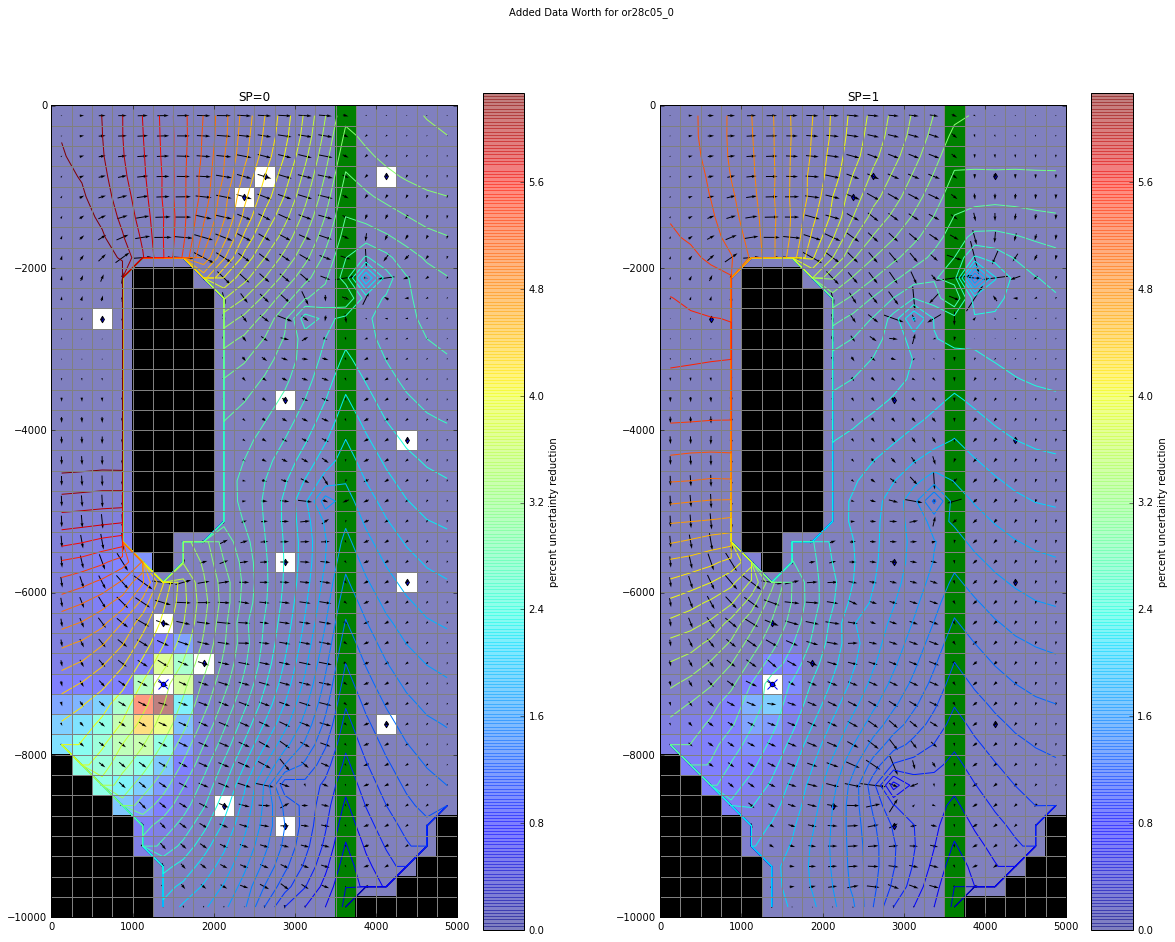

In [41]:
plot_added_importance(df_new_worth_plot, ml, 'or28c05_0')

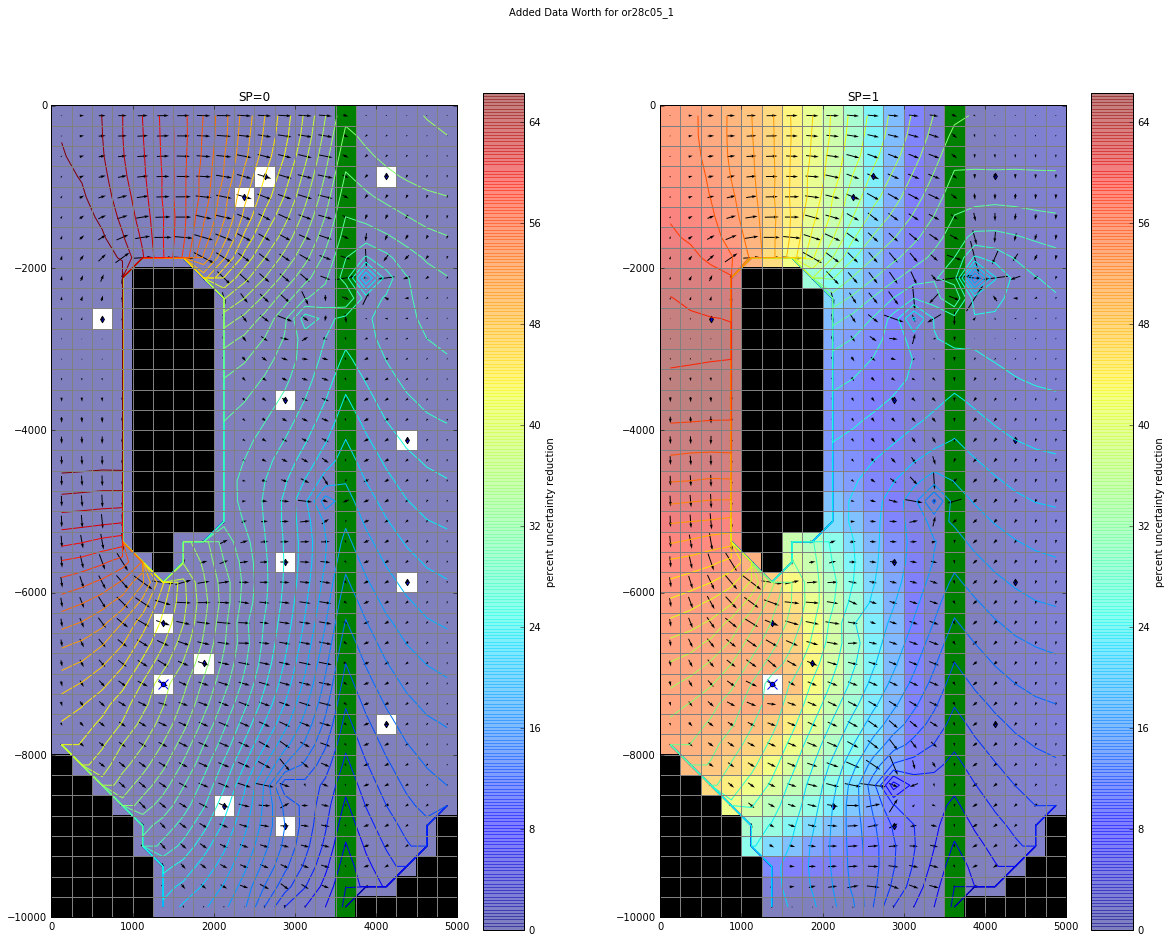

In [42]:
plot_added_importance(df_new_worth_plot, ml, 'or28c05_1')

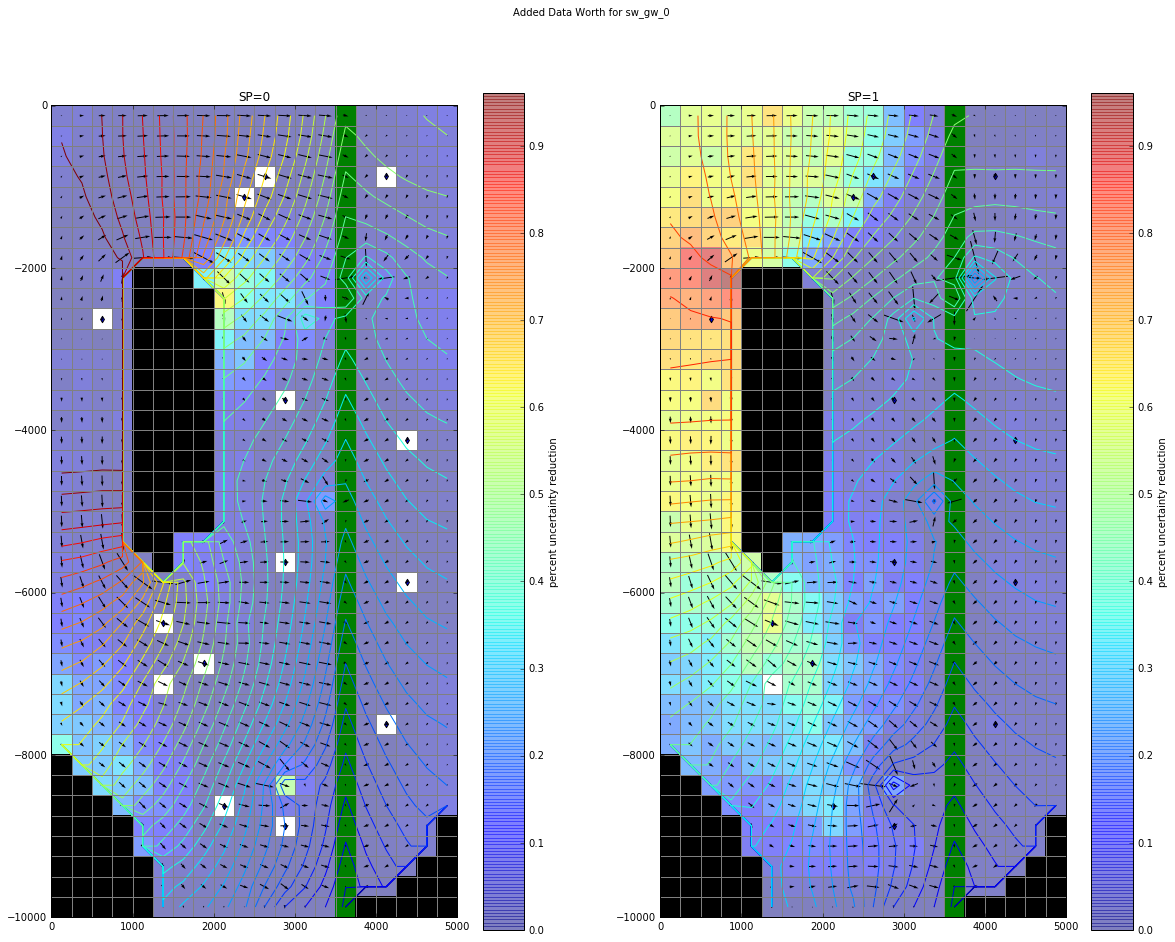

In [43]:
plot_added_importance(df_new_worth_plot, ml, 'sw_gw_0')

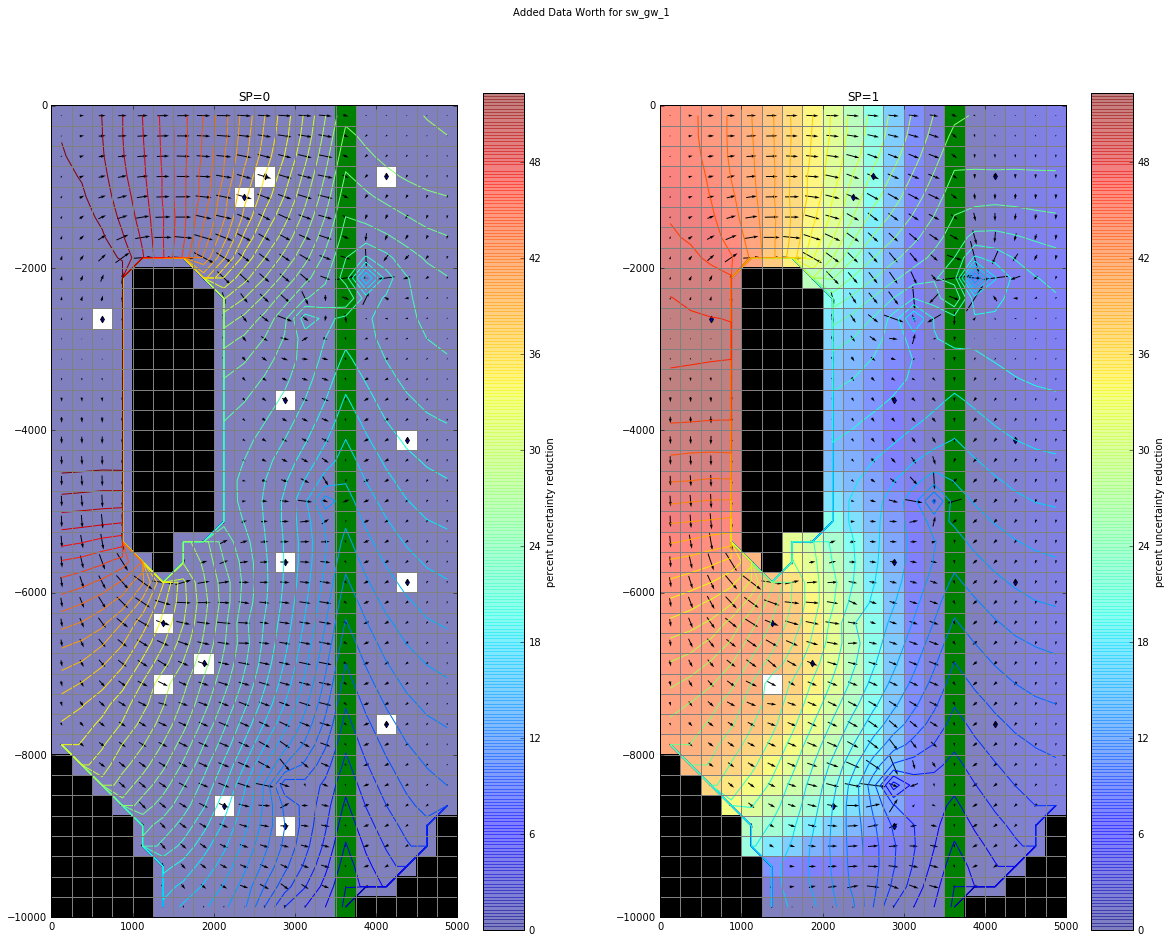

In [44]:
plot_added_importance(df_new_worth_plot, ml, 'sw_gw_1')

### Next most valuable point
Evaluating these data worth maps, an obvious question is raised--what is the next most valuable data point? The issue is, there is a high density of importance around the most valuable observation point but if that most valuable observation was part of the calibration dataset, we would expect the next most valuable point to be somewhere else. In order to evaluate that, we ned to recompute data worth assuming that the recently identified point was part of the calibration set. This requires iterative calculations made possible by FOSM using the method `next_most_important_added_obs`

In [45]:
next_df = la.next_most_important_added_obs(forecast='or28c05_1',niter=3, obslist_dict=dict(zip(new_obs_list,new_obs_list)),
                                           base_obslist=pst.nnz_obs_names,reset_zero_weight=True)

In [46]:
next_df

,or28c05_1
base,1.349353
or13c02_1,0.454074
or11c01_1,0.325773
or29c05_1,0.264476


## Parameter contribution to uncertainty
Lets look at which parameters are contributing most to forecast uncertainty.  for demostration purposes, lets group the parameters by parameter group name.

In [47]:
df = la.get_par_group_contribution()
df

or28c05_0                          or28c05_1                      \
        percent_reduce      post     prior percent_reduce      post     prior   
base         73.841701  0.104901  0.401023       7.343810  1.349353  1.456301   
welflux      73.841291  0.104642  0.400026       7.641788  1.292918  1.399895   
rch          65.768008  0.104280  0.304629      13.592741  0.692060  0.800928   
hk           99.749734  0.000244  0.097405       0.419918  1.261683  1.267003   
storage      73.841701  0.104901  0.401023      11.868901  0.794129  0.901077   
rcond        73.841795  0.104897  0.401010       7.344041  1.349350  1.456301   

               sw_gw_0                                    sw_gw_1  \
        percent_reduce          post         prior percent_reduce   
base         43.156275  45266.951772  79634.034592       0.110646   
welflux      43.743394  43617.767683  77533.592215       0.130449   
rch          12.301504   3900.047023   4447.108198       0.168021   
hk           98.743279    971.402233  77296.576233       0.134450   
storage      43.156275  45266.951772  79634.034592       0.129891   
rcond        43.177485  45244.828949  79624.827130       0.110633   

                                       
                  post          prior  
base     620442.618112  621129.872236  
welflux  527751.898672  528441.245961  
rch      185502.204821  185814.411201  
hk       619205.103398  620038.748077  
storage  528412.812692  529100.066815  
rcond    620437.848843  621125.016889

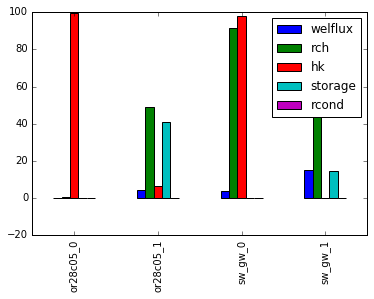

In [48]:
#select out the posterior column
df_reduce = df.xs("post",axis=1,level=1)
#calc the percent reduction in posterior
df_percent = 100.0 * (df_reduce.loc["base",:]-df_reduce)/df_reduce.loc["base",:]
#drop the base column
df_percent = df_percent.iloc[1:,:]
#transpose and plot
df_percent.T.plot(kind="bar")

We see some interesting results here.  The sw-gw flux during calibration (sw_gw_0) is influenced by both recharge and hk uncertainty, but the forecast period sw-gw flux is influenced most by forecast period recharge uncertainty.  unfortunately, model calibration does not tell us about forecast period forcing, so calibration doesn't help with this forecast.  For the water level forecasts (```or28c05_0 and or28c05_1```), the results are similar: the forecast of water level at the end of the calibration period benefits most from hk knowledge, while the forecast period water level is most by recharge and storage.  Let's do this same analysis, but now group the parameters differently:

In [50]:
pnames = la.pst.par_names
fore_names = [pname for pname in pnames if pname.endswith("_1")]
props = [pname for pname in pnames if pname[:2] in ["hk","ss","sy","rc"] and "rch" not in pname]
cal_names = [pname for pname in pnames if pname.endswith("_0")]
pdict = {'forecast forcing':fore_names,"properties":props,"calibration forcing":cal_names}
df = la.get_par_contribution(pdict)

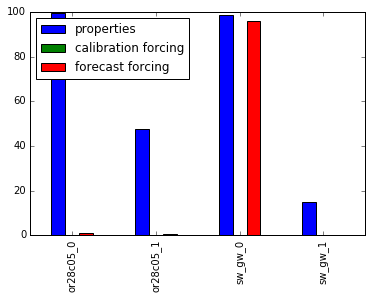

In [51]:
#select out the posterior column
df_reduce = df.xs("post",axis=1,level=1)
#calc the percent reduction in posterior
df_percent = 100.0 * (df_reduce.loc["base",:]-df_reduce)/df_reduce.loc["base",:]
#drop the base column
df_percent = df_percent.iloc[1:,:]
#transpose and plot
df_percent.T.plot(kind="bar")